In [1]:
#%%
"""
Created on Feb 11 2019
The Heston model discretization, Euler scheme vs. AES scheme
@author: Lech A. Grzelak
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum


In [2]:
# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

In [3]:
def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)

    # reshape K to a column vector
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])

    #assigning i=sqrt(-1)
    i = complex(0.0,1.0)
    x0 = np.log(S0 / K)

    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)

    # sumation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])
    u = k * np.pi / (b - a);

    # Determine coefficients for Put Prices
    H_k = CallPutCoefficients(CP,a,b,k)
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k
    temp[0] = 0.5 * temp[0]
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))
    return value

In [4]:
def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c

    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0))
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi *
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)

    value = {"chi":chi,"psi":psi }
    return value


In [5]:
# Determine coefficients for Put Prices
def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)
    return H_k


In [6]:
def ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rho):
    i = complex(0.0,1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*np.exp(-D1(u)*tau)))\
        *(kappa-gamma*rho*i*u-D1(u))
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    A  = lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*rho*i*u-D1(u))\
        - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))
    # Characteristic function for the Heston's model
    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf

In [7]:
def EUOptionPriceFromMCPathsGeneralized(CP,S,K,T,r):
    # S is a vector of Monte Carlo samples at T
    result = np.zeros([len(K),1])
    if CP == OptionType.CALL:
        for (idx,k) in enumerate(K):
            result[idx] = np.exp(-r*T)*np.mean(np.maximum(S-k,0.0))
    elif CP == OptionType.PUT:
        for (idx,k) in enumerate(K):
            result[idx] = np.exp(-r*T)*np.mean(np.maximum(k-S,0.0))
    return result

In [8]:
def GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    W2 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    X[:,0]=np.log(S_0)

    time = np.zeros([NoOfSteps+1])

    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
            Z2[:,i] = (Z2[:,i] - np.mean(Z2[:,i])) / np.std(Z2[:,i])
        Z2[:,i] = rho * Z1[:,i] + np.sqrt(1.0-rho**2)*Z2[:,i]

        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        W2[:,i+1] = W2[:,i] + np.power(dt, 0.5)*Z2[:,i]

        # Truncated boundary condition
        V[:,i+1] = V[:,i] + kappa*(vbar - V[:,i]) * dt + gamma* np.sqrt(V[:,i]) * (W1[:,i+1]-W1[:,i])
        V[:,i+1] = np.maximum(V[:,i+1],0.0)

        X[:,i+1] = X[:,i] + (r - 0.5*V[:,i])*dt + np.sqrt(V[:,i])*(W2[:,i+1]-W2[:,i])
        time[i+1] = time[i] +dt

    #Compute exponent
    S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths


In [9]:
def CIR_Sample(NoOfPaths,kappa,gamma,vbar,s,t,v_s):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t-s)))
    kappaBar = 4.0*kappa*v_s*np.exp(-kappa*(t-s))/(gamma*gamma*(1.0-np.exp(-kappa*(t-s))))
    sample = c* np.random.noncentral_chisquare(delta,kappaBar,NoOfPaths)
    return  sample

def GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    X[:,0]=np.log(S_0)

    time = np.zeros([NoOfSteps+1])

    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]

        # Exact samles for the variance process
        V[:,i+1] = CIR_Sample(NoOfPaths,kappa,gamma,vbar,0,dt,V[:,i])
        k0 = (r -rho/gamma*kappa*vbar)*dt
        k1 = (rho*kappa/gamma -0.5)*dt - rho/gamma
        k2 = rho / gamma
        X[:,i+1] = X[:,i] + k0 + k1*V[:,i] + k2 *V[:,i+1] + np.sqrt((1.0-rho**2)*V[:,i])*(W1[:,i+1]-W1[:,i])
        time[i+1] = time[i] +dt

    #Compute exponent
    S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths


In [10]:
# Black-Scholes Call option price
def BS_Call_Put_Option_Price(CP,S_0,K,sigma,t,T,r):
    #print('Maturity T={0} and t={1}'.format(T,t))
    #print(float(sigma * np.sqrt(T-t)))
    #print('strike K ={0}'.format(K))
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0))
    * (T-t)) / (sigma * np.sqrt(T-t))
    d2    = d1 - sigma * np.sqrt(T-t)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * (T-t))
     #   print(value)
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * (T-t)) - st.norm.cdf(-d1)*S_0
      #  print(value)
    return value


In [11]:
def mainCalculation():
    NoOfPaths = 2500
    NoOfSteps = 500

    # Heston model parameters
    gamma = 1.0
    kappa = 0.5
    vbar  = 0.04
    rho   = -0.9
    v0    = 0.04
    T     = 1.0
    S_0   = 100.0
    r     = 0.1
    CP    = OptionType.CALL

    # First we define a range of strikes and check the convergence
    K = np.linspace(80,S_0*1.5,30)

    # Exact solution with the COS method
    cf = ChFHestonModel(r,T,kappa,gamma,vbar,v0,rho)

    # The COS method
    optValueExact = CallPutOptionPriceCOSMthd(cf, CP, S_0, r, T, K, 1000, 8)

    # Euler simulation
    pathsEULER = GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
    S_Euler = pathsEULER["S"]

    # Almost exact simulation
    pathsAES = GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
    S_AES = pathsAES["S"]


    OptPrice_EULER = EUOptionPriceFromMCPathsGeneralized(CP,S_Euler[:,-1],K,T,r)
    OptPrice_AES   = EUOptionPriceFromMCPathsGeneralized(CP,S_AES[:,-1],K,T,r)

    plt.figure(1)
    plt.plot(K,optValueExact,'-r')
    plt.plot(K,OptPrice_EULER,'--k')
    plt.plot(K,OptPrice_AES,'.b')
    plt.legend(['Exact (COS)','Euler','AES'])
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('option price')

    # Here we will analyze the convergence for particular dt
    dtV = np.array([1.0, 1.0/4.0, 1.0/8.0,1.0/16.0,1.0/32.0,1.0/64.0])
    NoOfStepsV = [int(T/x) for x in dtV]

    # Specify strike for analysis
    K = np.array([140.0])

    # Exact
    optValueExact = CallPutOptionPriceCOSMthd(cf, CP, S_0, r, T, K, 1000, 8)
    errorEuler = np.zeros([len(dtV),1])
    errorAES = np.zeros([len(dtV),1])

    for (idx,NoOfSteps) in enumerate(NoOfStepsV):
        # Euler
        np.random.seed(3)
        pathsEULER = GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
        S_Euler = pathsEULER["S"]
        OptPriceEULER = EUOptionPriceFromMCPathsGeneralized(CP,S_Euler[:,-1],K,T,r)
        errorEuler[idx] = OptPriceEULER-optValueExact
        # AES
        np.random.seed(3)
        pathsAES = GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
        S_AES = pathsAES["S"]
        OptPriceAES   = EUOptionPriceFromMCPathsGeneralized(CP,S_AES[:,-1],K,T,r)
        errorAES[idx] = OptPriceAES-optValueExact

    # Print the results
    for i in range(0,len(NoOfStepsV)):
        print("Euler Scheme, K ={0}, dt = {1} = {2}".format(K,dtV[i],errorEuler[i]))

    for i in range(0,len(NoOfStepsV)):
        print("AES Scheme, K ={0}, dt = {1} = {2}".format(K,dtV[i],errorAES[i]))


Euler Scheme, K =[140.], dt = 1.0 = [1.30476871]
Euler Scheme, K =[140.], dt = 0.25 = [0.54404403]
Euler Scheme, K =[140.], dt = 0.125 = [0.1720427]
Euler Scheme, K =[140.], dt = 0.0625 = [0.08078707]
Euler Scheme, K =[140.], dt = 0.03125 = [0.01260589]
Euler Scheme, K =[140.], dt = 0.015625 = [0.00605332]
AES Scheme, K =[140.], dt = 1.0 = [0.00800533]
AES Scheme, K =[140.], dt = 0.25 = [0.00985109]
AES Scheme, K =[140.], dt = 0.125 = [0.00135139]
AES Scheme, K =[140.], dt = 0.0625 = [0.00661993]
AES Scheme, K =[140.], dt = 0.03125 = [0.0157029]
AES Scheme, K =[140.], dt = 0.015625 = [0.00699352]


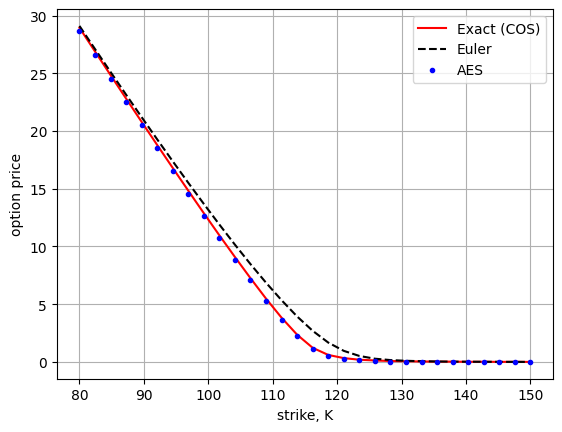

In [12]:
mainCalculation()